# Reinforcement Learning in OpenAI

Let's start buy installing the gym module:

In [73]:
!pip install gym
!pip install keras


In [74]:
import gym
import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle

from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, linear
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model

from collections import deque


Now, let's see how we can interact with the environment in OpenAI:

In [75]:
env = gym.make('CartPole-v0')
# create the CartPole-v0 gym environment
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4,)
Action space: Discrete(2)


In OpenAI environments, the input we give our agents is taken from the Observation space. In this case, Box(4,) refers to a continuous space. If we go to the CartPole-v1 documentation:(https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) we can see the observation space gives us 4 continuous observation (input) options, and 2 discrete action (output) options.

Now let's see how we can make a basic agent:

In [76]:
class RandomAgent():
    # create basicAgent class
    def __init__(self,env):
        # constructor
        self.action_size = env.action_space.n
        # number of available actions, in this case 2
        
    def get_action(self,state):
        # method for choosing action
        action = random.choice(range(self.action_size))
        # choose random action 
        return action 

Now that we have a basic agent that returns a random action, lets run it:

In [77]:
agent = RandomAgent(env)
# create agent object
state = env.reset() 
# reset environment state and define initial state
total_reward = 0

for _ in range(100):
    # loop for 100 iterations
    action = agent.get_action(state)
    # get action from agent passing in the state
    state, reward, done, info = env.step(action)
    # returns the state after action (env object)
    # env.render()
    # time.sleep(0.03)
    if not done:
        total_reward += reward
env.close()
print("Reward: {}".format(total_reward))

Reward: 34.0


Each environment has its own "Solved" requirements, and some remain unsolved, as can be seen on the Leaderboard: https://github.com/openai/gym/wiki/Leaderboard For the CartPole-v1 env, "done" returns True when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center, and "solving" is defined as getting average reward of 195.0 over 100 consecutive trials. A reward of +1 is provided for every timestep that the pole remains upright. Done also returns true when the reward is 200.

Obviously, our random agent isn't performing that well. Let's try and improve on this by giving it a non-random policy and interacting with the observation space:

In [78]:
class BasicPolicyAgent():
    def __init__(self,env):
        self.action_size = env.action_space.n
    def get_action(self, state):
        pole_angle = state[2]
        # index[2] of observation space
        action = 0 if pole_angle < 0 else 1
        # policy action, move left is angle < 0 else right
        return action

agent = BasicPolicyAgent(env)
state = env.reset()

total_reward = 0

for _ in range(100):
    action = agent.get_action(state)
    state, reward, done, info = env.step(action)
    # env.render()
    # time.sleep(0.03)
    if not done:
        total_reward += reward
env.close()
print("Reward: {}".format(total_reward))

Reward: 71.0


We can see that even with a very simple policy, the behavior is improved. Now we've seen how to interact with the environment and create agents.

Let's look at a simple implementation of the HillClimbing method. Essentially, we want a function that takes all the inputs (observations) available and outputs a vector with the predicted values of the next state of the environment based on a given action.

Essentially we want to transform our input state vector [1 4] to a [1 2] output action vector. We do this by multiplying the [1 4] matrix with a [4 2] weights matrix.

This weights matrix is initialized with random weights. We use this initial weights matrix to get our action (output) vector from our observation (input) vector. We calculate the total reward from the episode, and save it as our best reward. We also save the weights matrix as our best weights. We then sample a new random weights matrix, to which we add a random noise matrix of the same dimensions for variance. If the new total reward is higher than the best total reward, we use the weights that gave us this new higher reward and save them as best weights, and halve the noise matrix to decrease variance. If the new total reward is lower, we keep the old weights and double the noise matrix:

Run 0
Episode: 0, total_reward: 10.00
Episode: 1, total_reward: 79.00
Episode: 2, total_reward: 73.00
Episode: 3, total_reward: 8.00
Episode: 4, total_reward: 50.00
Episode: 5, total_reward: 8.00
Episode: 6, total_reward: 131.00
Episode: 7, total_reward: 200.00
Episode: 8, total_reward: 200.00
Episode: 9, total_reward: 162.00
Episode: 10, total_reward: 200.00
Episode: 11, total_reward: 200.00
Episode: 12, total_reward: 200.00
Episode: 13, total_reward: 200.00
Episode: 14, total_reward: 200.00
Episode: 15, total_reward: 200.00
Episode: 16, total_reward: 200.00
Episode: 17, total_reward: 200.00
Episode: 18, total_reward: 200.00
Episode: 19, total_reward: 200.00
Episode: 20, total_reward: 200.00
Episode: 21, total_reward: 200.00
Episode: 22, total_reward: 200.00
Episode: 23, total_reward: 200.00
Episode: 24, total_reward: 200.00
Episode: 25, total_reward: 200.00
Episode: 26, total_reward: 200.00
Episode: 27, total_reward: 200.00
Episode: 28, total_reward: 200.00
Episode: 29, total_reward:

Text(0, 0.5, 'Average Reward')

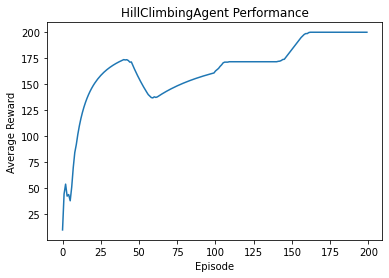

In [79]:
class HillClimbingAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        # shape or dimension of the env's observation_shape matrix
        self.action_size = env.action_space.n
        self.build_model()
        
    def build_model(self):
            self.weights = 1e-4*np.random.rand(*self.state_dim, self.action_size)
            # initialize random weights matrix
            self.best_reward = -np.Inf
            # initialize reward as lowest possible number
            self.best_weights = np.copy(self.weights)
            # initialize best_weights as first random weights matrix
            self.noise_scale = 1e-2
            # initialize noise scale
            
        
    def get_action(self, state):
            p = np.dot(state, self.weights)
            # dot product of state and weights
            action = np.argmax(p)
            # action is highest element in p
            return action
        
    def update_model(self, reward):
            if reward >= self.best_reward:
                self.best_reward = reward
                self.best_weights = np.copy(self.weights)
                self.noise_scale = max(self.noise_scale/2, 1e-3)
            else:
                self.noise_scale = min(self.noise_scale*2, 2)
                    
            self.weights = self.best_weights + self.noise_scale * np.random.rand(*self.state_dim, self.action_size)
            # sample new current weights by adding best weight and noise matrix scaled by new noise scale

env_name = 'CartPole-v0'
env = gym.make(env_name)
num_runs = 1
run_rewards = []

for n in range(num_runs):
  print("Run {}".format(n))
  ep_rewards = []
  agent = HillClimbingAgent(env)
  num_episodes = 200

  for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
      action = agent.get_action(state)
      state, reward, done, info = env.step(action)
      # env.render()
      total_reward += reward
      # time.sleep(0.03)

    ep_rewards.append(total_reward)
    agent.update_model(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)
env.close()

for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("HillClimbingAgent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")


After just 200 episodes, we can see that the agent is now able to keep the pole upright for the maximum 200 frames consistently (depending on how lucky you are with the random initialized weights matrix, this may take more episodes).

Let's try this method in a different gym environment. The acrobot system includes two joints and two links, where the joint between the two links is actuated. Initially, the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height. The action is either applying +1, 0 or -1 torque on the joint between the two pendulum links. The Observation space or state consists of the sin() and cos() of the two rotational joint angles and the joint angular velocities.

Run 0
Episode: 0, total_reward: -500.00
Episode: 1, total_reward: -500.00
Episode: 2, total_reward: -500.00
Episode: 3, total_reward: -500.00
Episode: 4, total_reward: -500.00
Episode: 5, total_reward: -500.00
Episode: 6, total_reward: -500.00
Episode: 7, total_reward: -500.00
Episode: 8, total_reward: -500.00
Episode: 9, total_reward: -500.00
Episode: 10, total_reward: -500.00
Episode: 11, total_reward: -500.00
Episode: 12, total_reward: -500.00
Episode: 13, total_reward: -500.00
Episode: 14, total_reward: -500.00
Episode: 15, total_reward: -500.00
Episode: 16, total_reward: -500.00
Episode: 17, total_reward: -500.00
Episode: 18, total_reward: -500.00
Episode: 19, total_reward: -500.00
Episode: 20, total_reward: -500.00
Episode: 21, total_reward: -500.00
Episode: 22, total_reward: -500.00
Episode: 23, total_reward: -500.00
Episode: 24, total_reward: -500.00
Episode: 25, total_reward: -500.00
Episode: 26, total_reward: -500.00
Episode: 27, total_reward: -500.00
Episode: 28, total_rewar

Text(0, 0.5, 'Average Reward')

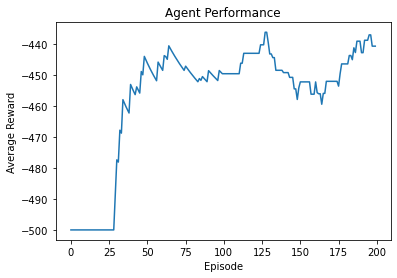

In [80]:
env_name = "Acrobot-v1"
env = gym.make(env_name)
num_runs = 1
run_rewards = []

for n in range(num_runs):
  print("Run {}".format(n))
  ep_rewards = []
  agent = HillClimbingAgent(env)
  num_episodes = 200

  for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
      action = agent.get_action(state)
      state, reward, done, info = env.step(action)
      # env.render()
      total_reward += reward
      # time.sleep(0.03)

    ep_rewards.append(total_reward)
    agent.update_model(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)
env.close()

for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("Agent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")

Now let's introduce Q-Learning; it is a reinforcement learning algorithm that aims to find the best action to take given a current state to maximize reward. This algorithm is considered off-policy due to the fact the Q-learning function learns from actions outside the current policy, like taking random actions.

The first step is to create a Q-table (or matrix) that follows the shape of [state, action] and we initialize each value in the matrix to zero. We update and store our Q-values in this matrix after each episode. This then becomes a reference table for our agent to select the best action based on the highest Q-value.

The second step is to interact with the environment, and update the state-action pairs in our Q-table. This is done in one of two ways: exploiting, or exploring. When exploiting, the Q-table is used as reference to view all possible actions for a given state, and the agent selects the action based on the max value of said action. When exploring, the action is taken randomly. This is important as it allows the agent to explore and discover new states that may not be selected during exploitation. These two modes of interaction with the environment are balanced using a variable usually named epsilon, which determines the probability of exploring versus exploiting.

We've mentioned epsilon (exploration probability), one of the hyperparameters, there are others that are useful. The learning rate, sometimes denoted alpha, is how much an updated value is "accepted" vs the old one. The difference between the new and old value is multiplied by this learning rate and added to the previous q-value. A discount factor, usually denoted gamma, can be used to balance immediate and future reward.

In [81]:
class QAgent():
    def __init__(self, env, buckets=(3, 3, 6, 6,), min_alpha=0.1, min_epsilon=0.1, gamma=1.0, ada_divisor=20):
        self.env = env # for choosing different environments
        self.buckets = buckets # down-scaling feature space to discrete range
        self.min_alpha = min_alpha # learning rate
        self.min_epsilon = min_epsilon # exploration rate
        self.gamma = gamma # discount factor
        self.ada_divisor = ada_divisor # decay rate parameter for alpha and epsilon

        # initialising Q-table
        self.Q = np.zeros(self.buckets + (self.env.action_space.n,))

    # Discretizing input space to make Q-table and to reduce dimmensionality
    def discretize(self, state):
        upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50)]
        lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50)]
        ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
        discretized_state = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(state))]
        discretized_state = [min(self.buckets[i] - 1, max(0, discretized_state[i])) for i in range(len(state))]
        return tuple(discretized_state)

    # Choosing action based on epsilon-greedy policy
    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.Q[state])

    # Updating Q-value of state-action pair based on the Bellman equation
    def update_q(self, state, action, reward, next_state, alpha):
        self.Q[state][action] += alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

    # Reduce Exploration Rate Over time
    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1, 1.0 - math.log10((t + 1) / self.ada_divisor)))

    # Reduce Learning Rate over time
    def get_alpha(self, t):
        return max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.ada_divisor)))


Run 0
Episode: 0, total_reward: 15.00
Episode: 1, total_reward: 12.00
Episode: 2, total_reward: 21.00
Episode: 3, total_reward: 16.00
Episode: 4, total_reward: 20.00
Episode: 5, total_reward: 18.00
Episode: 6, total_reward: 12.00
Episode: 7, total_reward: 23.00
Episode: 8, total_reward: 48.00
Episode: 9, total_reward: 14.00
Episode: 10, total_reward: 20.00
Episode: 11, total_reward: 14.00
Episode: 12, total_reward: 22.00
Episode: 13, total_reward: 32.00
Episode: 14, total_reward: 18.00
Episode: 15, total_reward: 21.00
Episode: 16, total_reward: 20.00
Episode: 17, total_reward: 17.00
Episode: 18, total_reward: 16.00
Episode: 19, total_reward: 20.00
Episode: 20, total_reward: 58.00
Episode: 21, total_reward: 40.00
Episode: 22, total_reward: 21.00
Episode: 23, total_reward: 37.00
Episode: 24, total_reward: 25.00
Episode: 25, total_reward: 32.00
Episode: 26, total_reward: 16.00
Episode: 27, total_reward: 17.00
Episode: 28, total_reward: 15.00
Episode: 29, total_reward: 18.00
Episode: 30, t

Text(0, 0.5, 'Average Reward')

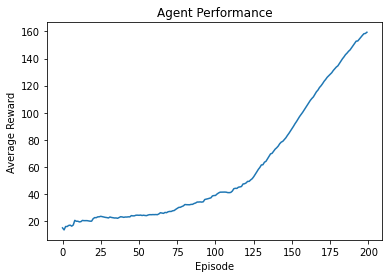

In [82]:
num_runs = 1
run_rewards = []
env = gym.make('CartPole-v0')

for n in range(num_runs):
  print("Run {}".format(n))
  ep_rewards = []
  num_episodes = 200
  agent = QAgent(env)

  for ep in range(num_episodes):
    # As states are continuous, discretize them into buckets
    discretized_state = agent.discretize(env.reset())

    # Get adaptive learning alpha and epsilon decayed over time
    alpha = agent.get_alpha(ep)
    epsilon = agent.get_epsilon(ep)
            
    total_reward = 0
    done = False
    i = 0
    
    while not done:
        # Choose action according to greedy policy and take it
        action = agent.choose_action(discretized_state, epsilon)
        state, reward, done, info = env.step(action)
        next_state = agent.discretize(state)
        # Update Q-Table
        agent.update_q(discretized_state, action, reward, next_state, alpha)
        discretized_state = next_state
        i += 1
        # env.render()
        total_reward += reward
        # time.sleep(0.03)
    ep_rewards.append(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)
env.close()

for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("Agent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")

In [83]:
class DQNAgent:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay):

        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.counter = 0

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.rewards_list = []

        self.replay_memory_buffer = deque(maxlen=500000)
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.num_action_space = self.action_space.n
        self.num_observation_space = env.observation_space.shape[0]
        self.model = self.initialize_model()

    def initialize_model(self):
        model = Sequential()
        # This is where we add the NN?
        model.add(Dense(512, input_dim=self.num_observation_space, activation=relu))
        model.add(Dense(256, activation=relu))
        model.add(Dense(self.num_action_space, activation=linear))

        # Compile the model
        model.compile(loss=mean_squared_error,optimizer=Adam(lr=self.lr))
        print(model.summary())
        return model

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # Make random / exploratory choice if random number smaller than current epsilon.
            return random.randrange(self.num_action_space)

        # Otherwise make exploitatory action, where the future states are predicted and an appropriate action taken.
        predicted_actions = self.model.predict(state)
        return np.argmax(predicted_actions[0])

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def learn_and_update_weights_by_reply(self):

        # replay_memory_buffer size check
        if len(self.replay_memory_buffer) < self.batch_size or self.counter != 0:
            return

        # Early Stopping
        if np.mean(self.rewards_list[-10:]) > 180:
            return

        random_sample = self.get_random_sample_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attribues_from_sample(random_sample)
        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = self.model.predict_on_batch(states)
        indexes = np.array([i for i in range(self.batch_size)])
        target_vec[[indexes], [actions]] = targets

        self.model.fit(states, target_vec, epochs=1, verbose=0)

    def get_attribues_from_sample(self, random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_from_replay_mem(self):
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

  

    def update_counter(self):
        self.counter += 1
        step_size = 5
        self.counter = self.counter % step_size

    def save(self, name):
        self.model.save(name)

Training Run 0
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               4608      
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 1028      
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None
Episode: 0, total_reward: -86.16, last_step_reward: -100.000
Episode: 1, total_reward: -257.17, last_step_reward: -100.000
Episode: 2, total_reward: -123.63, last_step_reward: -100.000
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense) 

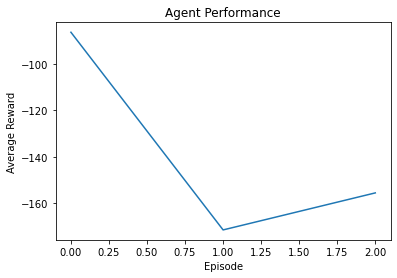

In [84]:
num_runs = 1
run_rewards = []
env = gym.make('LunarLander-v2')
lr = 0.001
epsilon = 1.0
epsilon_decay = 0.995
gamma = 0.99
def train(agent, can_stop = True):
  for n in range(num_runs):
      print("Training Run {}".format(n))
      ep_rewards = []
      num_episodes = 3
      agent = DQNAgent(env, lr, epsilon, epsilon_decay, gamma)
      
      for ep in range(num_episodes):
          state = env.reset()
          total_reward = 0
          num_steps = 1000
          state = np.reshape(state, [1, agent.num_observation_space])
          for step in range(num_steps):
              # env.render()
              # time.sleep(0.0003)
              received_action = agent.get_action(state)
              next_state, reward, done, info = env.step(received_action)
              next_state = np.reshape(next_state, [1, agent.num_observation_space])
              agent.add_to_replay_memory(state, received_action, reward, next_state, done)
              total_reward += reward
              state = next_state
              agent.update_counter()
              agent.learn_and_update_weights_by_reply()  

              if done: 
                break

              if agent.epsilon > agent.epsilon_min:
                agent.epsilon *= agent.epsilon_decay

              last_rewards_mean = np.mean(agent.rewards_list[-100:])
              if last_rewards_mean > 200 and can_stop:
                print("DQN Training Complete...")
                break

          ep_rewards.append(total_reward)
          print("Episode: {}, total_reward: {:.2f}, last_step_reward: {:.3f}".format(ep, total_reward, reward))
  run_rewards.append(ep_rewards)
  env.close()

  for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    plt.plot(x, avgs)
  plt.title("Agent Performance")
  plt.xlabel("Episode")
  plt.ylabel("Average Reward")

train(DQNAgent, True)
save_dir = "saved_models_"
model = DQNAgent(env, lr, epsilon, epsilon_decay, gamma)
model.save(save_dir + "trained_model.h5")


In [85]:
num_runs = 1
run_rewards = []

def test_trained_model(agent, trained_model):
    for n in range(num_runs):
      print("Testing Run {}".format(n))
      ep_rewards = []
      num_episodes = 10
      agent = DQNAgent(env, lr, epsilon, epsilon_decay, gamma)

      for ep in range(num_episodes):
          current_state = env.reset()
          num_observation_space = env.observation_space.shape[0]
          current_state = np.reshape(current_state, [1, num_observation_space])
          total_reward = 0
          num_steps = 1000

          for step in range(num_steps):
              # env.render()
              # time.sleep(0.0003)
              selected_action = np.argmax(trained_model.predict(current_state)[0])
              new_state, reward, done, info = env.step(selected_action)
              new_state = np.reshape(new_state, [1, num_observation_space])
              current_state = new_state
              total_reward += reward
              if done:
                  break
          ep_rewards.append(total_reward)
          print("Episode: {}, total_reward: {:.2f}, last_step_reward: {:.3f}".format(ep, total_reward, reward))
    run_rewards.append(ep_rewards)
    env.close()

    for n, ep_rewards in enumerate(run_rewards):
        x = range(len(ep_rewards))
        cumsum = np.cumsum(ep_rewards)
        avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
        plt.plot(x, avgs)
    plt.title("Agent Performance")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")




Testing Run 0
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               4608      
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 1028      
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None
Episode: 0, total_reward: -495.43, last_step_reward: -100.000
Episode: 1, total_reward: -567.54, last_step_reward: -100.000
Episode: 2, total_reward: -584.28, last_step_reward: -100.000
Episode: 3, total_reward: -888.89, last_step_reward: -100.000
Episode: 4, total_reward: -1980.97, last_step_reward: -100.000
Episode: 5, total_reward: -620.21, last_step_re

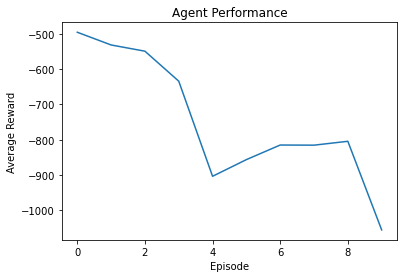

In [86]:
save_dir = "saved_models_"
trained_model = load_model(save_dir + "trained_model.h5")
test_trained_model(DQNAgent, trained_model)